In [1]:
import sys
!pip install -qq /kaggle/input/mmdetection/einops-0.4.1-py3-none-any.whl
sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master/')
sys.path.append('../input/hubmap-coat') 
sys.path.append("../input/segmentation-models-pytorch/segmentation_models.pytorch-0.2.1/")
sys.path.append("../input/pretrainedmodels/pretrainedmodels-0.7.4")
sys.path.append("../input/efficientnet-pytorch/EfficientNet-PyTorch-master")
sys.path.append('/kaggle/input/hubmap-coat/')
import segmentation_models_pytorch as smp
import cv2
import os 
import tifffile as tiff
import pandas as pd
import importlib
from timeit import default_timer as timer
from torch import nn
import torch
import torch.cuda.amp as amp
import torch.nn.functional as F
import math
from coat import *
from daformer import *
from helper import *
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt
import torch.nn

In [2]:
organ_threshold = {
    'Hubmap': {
        'kidney'        : 0.40,
        'prostate'      : 0.40,
        'largeintestine': 0.40,
        'spleen'        : 0.40,
        'lung'          : 0.10,
    },
    'HPA': {
        'kidney'        : 0.50,
        'prostate'      : 0.50,
        'largeintestine': 0.50,
        'spleen'        : 0.50,
        'lung'          : 0.10,
    },
}

data_source =['Hubmap', 'HPA']
organ = ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']

def get_net(Net,encoder,ckpt_list,weight_list):
    model = Net(encoder=encoder).cuda()
    model = use_swa_model(model,ckpt_list,weight_list,True)
    return model

In [3]:
def use_swa_model(model,
              checkpoint_list,
              weight_list,
              strict):

    checkpoint_tensor_list = [torch.load(f)['state_dict'] for f in checkpoint_list]

    for name, param in model.named_parameters():
            param.data = sum([ckpt[name] * w for ckpt, w in zip(checkpoint_tensor_list, weight_list)])
    return model

In [4]:
valid_file = '../input/hubmap-organ-segmentation/test.csv'
tiff_dir   = '../input/hubmap-organ-segmentation/test_images'

valid_df = pd.read_csv(valid_file)
valid_df.loc[:,'img_area']=valid_df['img_height']*valid_df['img_width']
valid_df = valid_df.sort_values('img_area').reset_index(drop=True)

In [5]:
class Net_parallel_small(nn.Module):
    def __init__(self,encoder,decoder=daformer_conv1x1,   
                encoder_cfg={},
                decoder_cfg={},
                ):  # decoder = daformer_conv3x3,   for coat-medium
        super(Net_parallel_small, self).__init__()
        decoder_dim = decoder_cfg.get('decoder_dim', 320)

        # ----
        self.output_type = ['inference', 'loss']


        self.rgb = RGB()



        self.encoder = encoder

        encoder_dim = self.encoder.embed_dims
        self.decoder = decoder(
          encoder_dim=encoder_dim,
          decoder_dim=decoder_dim,
        )
        self.logit = nn.Sequential(
          nn.Conv2d(decoder_dim, 1, kernel_size=1),
        )
        self.aux = nn.ModuleList([
                nn.Conv2d(decoder_dim, 1, kernel_size=1, padding=0) for i in range(4)
            ])


    def forward(self, batch):
        x = batch['image']
        num_class = 5
        x = self.rgb(x)
        B, C, H, W = x.shape
        encoder = self.encoder(x)
        last, decoder = self.decoder(encoder)

        logit = self.logit(last)
        logit = F.interpolate(logit, size=None, scale_factor=4, mode='bilinear', align_corners=False)

        output = {}
        if 'loss' in self.output_type:
              output['bce_loss'] = F.binary_cross_entropy_with_logits(logit,batch['mask'])
              output['dice_loss'] = smp.losses.DiceLoss(mode='binary')(logit,batch['mask'])

              for i in range(4):
                output['aux%d_loss'%i] = criterion_aux_loss(self.aux[i](decoder[i]),batch['mask'])
        if 'inference' in self.output_type:
              probability_from_logit = torch.sigmoid(logit)
              output['probability'] = probability_from_logit
        return output
    


class Net_parallel_medium(nn.Module):
    def __init__(self,encoder,decoder=daformer_conv3x3,   
                encoder_cfg={},
                decoder_cfg={},
                ):  # decoder = daformer_conv3x3,   for coat-medium
        super(Net_parallel_medium, self).__init__()
        decoder_dim = decoder_cfg.get('decoder_dim', 320)

        # ----
        self.output_type = ['inference', 'loss']


        self.rgb = RGB()



        self.encoder = encoder

        encoder_dim = self.encoder.embed_dims
        self.decoder = decoder(
          encoder_dim=encoder_dim,
          decoder_dim=decoder_dim,
        )
        self.logit = nn.Sequential(
          nn.Conv2d(decoder_dim, 1, kernel_size=1),
        )
        self.aux = nn.ModuleList([
                nn.Conv2d(decoder_dim, 1, kernel_size=1, padding=0) for i in range(4)
            ])


    def forward(self, batch):
        x = batch['image']
        num_class = 5
        x = self.rgb(x)
        B, C, H, W = x.shape
        encoder = self.encoder(x)
        last, decoder = self.decoder(encoder)

        logit = self.logit(last)
        logit = F.interpolate(logit, size=None, scale_factor=4, mode='bilinear', align_corners=False)

        output = {}
        if 'loss' in self.output_type:
              output['bce_loss'] = F.binary_cross_entropy_with_logits(logit,batch['mask'])
              output['dice_loss'] = smp.losses.DiceLoss(mode='binary')(logit,batch['mask'])

              for i in range(4):
                output['aux%d_loss'%i] = criterion_aux_loss(self.aux[i](decoder[i]),batch['mask'])
        if 'inference' in self.output_type:
              probability_from_logit = torch.sigmoid(logit)
              output['probability'] = probability_from_logit
        return output
    

In [6]:
class Mlp(nn.Module):
	def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., linear=False):
		super().__init__()
		out_features = out_features or in_features
		hidden_features = hidden_features or in_features
		self.fc1 = nn.Linear(in_features, hidden_features)
		self.dwconv = DWConv(hidden_features)
		self.act = act_layer()
		self.fc2 = nn.Linear(hidden_features, out_features)
		self.drop = nn.Dropout(drop)
		self.linear = linear
		if self.linear:
			self.relu = nn.ReLU(inplace=True)
		self.apply(self._init_weights)
	
	def _init_weights(self, m):
		if isinstance(m, nn.Linear):
			trunc_normal_(m.weight, std=.02)
			if isinstance(m, nn.Linear) and m.bias is not None:
				nn.init.constant_(m.bias, 0)
		elif isinstance(m, nn.LayerNorm):
			nn.init.constant_(m.bias, 0)
			nn.init.constant_(m.weight, 1.0)
		elif isinstance(m, nn.Conv2d):
			fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
			fan_out //= m.groups
			m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
			if m.bias is not None:
				m.bias.data.zero_()
	
	def forward(self, x, H, W):
		x = self.fc1(x)
		if self.linear:
			x = self.relu(x)
		x = self.dwconv(x, H, W)
		x = self.act(x)
		x = self.drop(x)
		x = self.fc2(x)
		x = self.drop(x)
		return x


class Attention(nn.Module):
	def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1, linear=False):
		super().__init__()
		assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."
		
		self.dim = dim
		self.num_heads = num_heads
		head_dim = dim // num_heads
		self.scale = qk_scale or head_dim ** -0.5
		
		self.q = nn.Linear(dim, dim, bias=qkv_bias)
		self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
		self.attn_drop = nn.Dropout(attn_drop)
		self.proj = nn.Linear(dim, dim)
		self.proj_drop = nn.Dropout(proj_drop)
		
		self.linear = linear
		self.sr_ratio = sr_ratio
		if not linear:
			if sr_ratio > 1:
				self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
				self.norm = nn.LayerNorm(dim)
		else:
			self.pool = nn.AdaptiveAvgPool2d(7)
			self.sr = nn.Conv2d(dim, dim, kernel_size=1, stride=1)
			self.norm = nn.LayerNorm(dim)
			self.act = nn.GELU()
		self.apply(self._init_weights)
	
	def _init_weights(self, m):
		if isinstance(m, nn.Linear):
			trunc_normal_(m.weight, std=.02)
			if isinstance(m, nn.Linear) and m.bias is not None:
				nn.init.constant_(m.bias, 0)
		elif isinstance(m, nn.LayerNorm):
			nn.init.constant_(m.bias, 0)
			nn.init.constant_(m.weight, 1.0)
		elif isinstance(m, nn.Conv2d):
			fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
			fan_out //= m.groups
			m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
			if m.bias is not None:
				m.bias.data.zero_()
	
	def forward(self, x, H, W):
		B, N, C = x.shape
		q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
		
		if not self.linear:
			if self.sr_ratio > 1:
				x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
				x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
				x_ = self.norm(x_)
				kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
			else:
				kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
		else:
			x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
			x_ = self.sr(self.pool(x_)).reshape(B, C, -1).permute(0, 2, 1)
			x_ = self.norm(x_)
			x_ = self.act(x_)
			kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
		k, v = kv[0], kv[1]
		
		attn = (q @ k.transpose(-2, -1)) * self.scale
		attn = attn.softmax(dim=-1)
		attn = self.attn_drop(attn)
		
		x = (attn @ v).transpose(1, 2).reshape(B, N, C)
		x = self.proj(x)
		x = self.proj_drop(x)
		
		return x


class Block(nn.Module):
	
	def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
	             drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1, linear=False):
		super().__init__()
		self.norm1 = norm_layer(dim)
		self.attn = Attention(
			dim,
			num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
			attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio, linear=linear)
		# NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
		self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
		self.norm2 = norm_layer(dim)
		mlp_hidden_dim = int(dim * mlp_ratio)
		self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop, linear=linear)
		
		self.apply(self._init_weights)
	
	def _init_weights(self, m):
		if isinstance(m, nn.Linear):
			trunc_normal_(m.weight, std=.02)
			if isinstance(m, nn.Linear) and m.bias is not None:
				nn.init.constant_(m.bias, 0)
		elif isinstance(m, nn.LayerNorm):
			nn.init.constant_(m.bias, 0)
			nn.init.constant_(m.weight, 1.0)
		elif isinstance(m, nn.Conv2d):
			fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
			fan_out //= m.groups
			m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
			if m.bias is not None:
				m.bias.data.zero_()
	
	def forward(self, x, H, W):
		x = x + self.drop_path(self.attn(self.norm1(x), H, W))
		x = x + self.drop_path(self.mlp(self.norm2(x), H, W))
		
		return x


class OverlapPatchEmbed(nn.Module):
	""" Image to Patch Embedding
	"""
	
	def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
		super().__init__()
		
		img_size = to_2tuple(img_size)
		patch_size = to_2tuple(patch_size)
		
		assert max(patch_size) > stride, "Set larger patch_size than stride"
		
		self.img_size = img_size
		self.patch_size = patch_size
		self.H, self.W = img_size[0] // stride, img_size[1] // stride
		self.num_patches = self.H * self.W
		self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
		                      padding=(patch_size[0] // 2, patch_size[1] // 2))
		self.norm = nn.LayerNorm(embed_dim)
		
		self.apply(self._init_weights)
	
	def _init_weights(self, m):
		if isinstance(m, nn.Linear):
			trunc_normal_(m.weight, std=.02)
			if isinstance(m, nn.Linear) and m.bias is not None:
				nn.init.constant_(m.bias, 0)
		elif isinstance(m, nn.LayerNorm):
			nn.init.constant_(m.bias, 0)
			nn.init.constant_(m.weight, 1.0)
		elif isinstance(m, nn.Conv2d):
			fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
			fan_out //= m.groups
			m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
			if m.bias is not None:
				m.bias.data.zero_()
	
	def forward(self, x):
		x = self.proj(x)
		_, _, H, W = x.shape
		x = x.flatten(2).transpose(1, 2)
		x = self.norm(x)
		
		return x, H, W


class PyramidVisionTransformerV2(nn.Module):
	def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dims=[64, 128, 256, 512],
	             num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
	             attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
	             depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1], num_stages=4,
	             linear=False,
	             pretrain=None
	             ):
		super().__init__()
		self.pretrain = pretrain
		self.embed_dims = embed_dims
		
		self.num_classes = num_classes
		self.depths = depths
		self.num_stages = num_stages
		
		dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
		cur = 0
		
		for i in range(num_stages):
			patch_embed = OverlapPatchEmbed(img_size=img_size if i == 0 else img_size // (2 ** (i + 1)),
			                                patch_size=7 if i == 0 else 3,
			                                stride=4 if i == 0 else 2,
			                                in_chans=in_chans if i == 0 else embed_dims[i - 1],
			                                embed_dim=embed_dims[i])
			
			block = nn.ModuleList([Block(
				dim=embed_dims[i], num_heads=num_heads[i], mlp_ratio=mlp_ratios[i], qkv_bias=qkv_bias, qk_scale=qk_scale,
				drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + j], norm_layer=norm_layer,
				sr_ratio=sr_ratios[i], linear=linear)
				for j in range(depths[i])])
			norm = norm_layer(embed_dims[i])
			cur += depths[i]
			
			setattr(self, f"patch_embed{i + 1}", patch_embed)
			setattr(self, f"block{i + 1}", block)
			setattr(self, f"norm{i + 1}", norm)
		
		# classification head
		self.head = nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()
		
		self.apply(self._init_weights)
	
	def _init_weights(self, m):
		if isinstance(m, nn.Linear):
			trunc_normal_(m.weight, std=.02)
			if isinstance(m, nn.Linear) and m.bias is not None:
				nn.init.constant_(m.bias, 0)
		elif isinstance(m, nn.LayerNorm):
			nn.init.constant_(m.bias, 0)
			nn.init.constant_(m.weight, 1.0)
		elif isinstance(m, nn.Conv2d):
			fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
			fan_out //= m.groups
			m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
			if m.bias is not None:
				m.bias.data.zero_()
	
	def freeze_patch_emb(self):
		self.patch_embed1.requires_grad = False
	
	@torch.jit.ignore
	def no_weight_decay(self):
		return {'pos_embed1', 'pos_embed2', 'pos_embed3', 'pos_embed4', 'cls_token'}  # has pos_embed may be better
	
	def get_classifier(self):
		return self.head
	
	def reset_classifier(self, num_classes, global_pool=''):
		self.num_classes = num_classes
		self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
	
	#https://github.com/whai362/PVT/blob/v2/segmentation/pvt.py
	def forward(self, x):
		outs = []
		B = x.shape[0]
		
		for i in range(self.num_stages):
			patch_embed = getattr(self, f"patch_embed{i + 1}")
			block = getattr(self, f"block{i + 1}")
			norm = getattr(self, f"norm{i + 1}")
			x, H, W = patch_embed(x)
			for blk in block:
				x = blk(x, H, W)
			x = norm(x)
			#if i != self.num_stages - 1:
			#	x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
			x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
			outs.append(x)
			
		return outs
 


class DWConv(nn.Module):
	def __init__(self, dim=768):
		super(DWConv, self).__init__()
		self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)
	
	def forward(self, x, H, W):
		B, N, C = x.shape
		x = x.transpose(1, 2).view(B, C, H, W)
		x = self.dwconv(x)
		x = x.flatten(2).transpose(1, 2)
		
		return x


def _conv_filter(state_dict, patch_size=16):
	""" convert patch embedding weight from manual patchify + linear proj to conv"""
	out_dict = {}
	for k, v in state_dict.items():
		if 'patch_embed.proj.weight' in k:
			v = v.reshape((v.shape[0], 3, patch_size, patch_size))
		out_dict[k] = v
	
	return out_dict


class pvt_v2_b4 (PyramidVisionTransformerV2):
	def __init__(self, **kwargs):
		super(pvt_v2_b4, self).__init__(
			patch_size=4,
			embed_dims=[64, 128, 320, 512],
			num_heads=[1, 2, 5, 8],
			mlp_ratios=[8, 8, 4, 4],
			qkv_bias=True,
			norm_layer=partial(nn.LayerNorm, eps=1e-6),
			depths=[3, 8, 27, 3],
			sr_ratios=[8, 4, 2, 1],
			drop_path_rate=0.3,
			pretrain ='pvt_v2_b4.pth',
			**kwargs)

class pvt_v2_b5 (PyramidVisionTransformerV2):
	def __init__(self, **kwargs):
		super(pvt_v2_b5, self).__init__(
			patch_size=4,
			embed_dims=[64, 128, 320, 512],
			num_heads=[1, 2, 5, 8],
			mlp_ratios=[4, 4, 4, 4],
			qkv_bias=True,
			norm_layer=partial(nn.LayerNorm, eps=1e-6),
			depths=[3, 6, 40, 3],
			sr_ratios=[8, 4, 2, 1],
			drop_path_rate=0.3,
			pretrain ='pvt_v2_b5.pth',
			**kwargs)

class Net_2(nn.Module):
    def __init__(self,
            encoder=pvt_v2_b4,
            decoder=daformer_conv3x3,
            encoder_cfg=dict(),
            decoder_cfg=dict()):
      super(Net_2, self).__init__()
      decoder_dim = decoder_cfg.get('decoder_dim', 320)
      
      # ----
      
      self.rgb = RGB()
      
      self.encoder = encoder
      encoder_dim = self.encoder.embed_dims
      # [64, 128, 320, 512]
      
      self.decoder = decoder(
        encoder_dim=encoder_dim,
        decoder_dim=decoder_dim,
      )
      self.logit = nn.Sequential(
        nn.Conv2d(decoder_dim, 1, kernel_size=1),
      )

      self.aux = nn.ModuleList([
            nn.Conv2d(decoder_dim, 1, kernel_size=1, padding=0) for i in range(4)
        ])
  
    def forward(self,batch):
          x = batch['image']
          x = self.rgb(x)
          B, C, H, W = x.shape
          encoder = self.encoder(x)
          #print([f.shape for f in encoder])

          last, decoder = self.decoder(encoder)
          logit = self.logit(last)
          # print(logit.shape)

          output = {}
          # output['probability'] = probability_from_logit
          logit = F.interpolate(logit, size=None, scale_factor=4, mode='bilinear', align_corners=False)
          if 'loss' in self.output_type:
            output['bce_loss'] = F.binary_cross_entropy_with_logits(logit,batch['mask'])
            output['dice_loss'] = smp.losses.DiceLoss(mode='binary')(logit,batch['mask'])

            for i in range(4):
              output['aux%d_loss'%i] = criterion_aux_loss(self.aux[i](decoder[i]),batch['mask'])
          if 'inference' in self.output_type:
            probability_from_logit = torch.sigmoid(logit)
            output['probability'] = probability_from_logit
          return output

In [7]:
checkpoint_v1 = ['../input/hubmap-dataset-v2/coat_small_aug3_768/coat_nodecoder_best_dice_score_model_aug3_0_small.pth','../input/hubmap-dataset-v2/coat_small_aug3_768/coat_nodecoder_best_best_dice_score_model_aug3_0_small.pth','../input/hubmap-dataset-v2/coat_small_aug3_768/coat_nodecoder_best_dice_loss_model_aug3_0_small.pth']
checkpoint_v2 = ['../input/hubmap-dataset-v2/coat_small_aug3_768/coat_nodecoder_best_dice_score_model_aug3_1_small.pth','../input/hubmap-dataset-v2/coat_small_aug3_768/coat_nodecoder_best_best_dice_score_model_aug3_1_small.pth','../input/hubmap-dataset-v2/coat_small_aug3_768/coat_nodecoder_best_dice_loss_model_aug3_1_small.pth']
checkpoint_v3 = ['../input/hubmap-dataset-v2/coat_small_aug3_768/coat_nodecoder_best_dice_score_model_aug3_2_small.pth','../input/hubmap-dataset-v2/coat_small_aug3_768/coat_nodecoder_best_best_dice_score_model_aug3_2_small.pth','../input/hubmap-dataset-v2/coat_small_aug3_768/coat_nodecoder_best_dice_loss_model_aug3_2_small.pth']
checkpoint_v4 = ['../input/hubmap-dataset-v2/coat_small_aug3_768/coat_nodecoder_best_dice_score_model_aug3_3_small.pth','../input/hubmap-dataset-v2/coat_small_aug3_768/coat_nodecoder_best_best_dice_score_model_aug3_3_small.pth','../input/hubmap-dataset-v2/coat_small_aug3_768/coat_nodecoder_best_dice_loss_model_aug3_3_small.pth']
checkpoint_v5 = ['../input/hubmap-dataset-v2/coat_small_aug3_768/coat_nodecoder_best_dice_score_model_aug3_4_small.pth','../input/hubmap-dataset-v2/coat_small_aug3_768/coat_nodecoder_best_best_dice_score_model_aug3_4_small.pth','../input/hubmap-dataset-v2/coat_small_aug3_768/coat_nodecoder_best_dice_loss_model_aug3_4_small.pth']

checkpoint_medium_v1 = ['../input/hubmap-dataset-v2/coat_medium_aug3/coat_nodecoder_best_dice_score_model_aug2_5level_0_stain_medium33.pth','../input/hubmap-dataset-v2/coat_medium_aug3/coat_nodecoder_best_dice_loss_model_aug2_5level_0_stain_medium33.pth','../input/hubmap-dataset-v2/coat_medium_aug3/coat_nodecoder_best_best_dice_score_model_aug2_5level_0_stain_medium33.pth']
checkpoint_medium_v2 = ['../input/hubmap-dataset-v2/coat_medium_aug3/coat_nodecoder_best_dice_score_model_aug2_5level_1_stain_medium33.pth','../input/hubmap-dataset-v2/coat_medium_aug3/coat_nodecoder_best_dice_loss_model_aug2_5level_1_stain_medium33.pth','../input/hubmap-dataset-v2/coat_medium_aug3/coat_nodecoder_best_best_dice_score_model_aug2_5level_1_stain_medium33.pth']
checkpoint_medium_v3 = ['../input/hubmap-dataset-v2/coat_medium_aug3/coat_nodecoder_best_dice_score_model_aug2_5level_2_stain_medium33.pth','../input/hubmap-dataset-v2/coat_medium_aug3/coat_nodecoder_best_dice_loss_model_aug2_5level_2_stain_medium33.pth','../input/hubmap-dataset-v2/coat_medium_aug3/coat_nodecoder_best_best_dice_score_model_aug2_5level_2_stain_medium33.pth']
checkpoint_medium_v4 = ['../input/hubmap-dataset-v2/coat_medium_aug3/coat_nodecoder_best_dice_score_model_aug2_5level_3_stain_medium33.pth','../input/hubmap-dataset-v2/coat_medium_aug3/coat_nodecoder_best_dice_loss_model_aug2_5level_3_stain_medium33.pth','../input/hubmap-dataset-v2/coat_medium_aug3/coat_nodecoder_best_best_dice_score_model_aug2_5level_3_stain_medium33.pth']
checkpoint_medium_v5 = ['../input/hubmap-dataset-v2/coat_medium_aug3/coat_nodecoder_best_dice_score_model_aug2_5level_4_stain_medium33.pth','../input/hubmap-dataset-v2/coat_medium_aug3/coat_nodecoder_best_dice_loss_model_aug2_5level_4_stain_medium33.pth','../input/hubmap-dataset-v2/coat_medium_aug3/coat_nodecoder_best_best_dice_score_model_aug2_5level_4_stain_medium33.pth']

checkpoint_pvt_v1 = ['../input/hubmap-dataset-v2/stain_pvt/coat_nodecoder_best_dice_score_model_aug3_0_pvt.pth','../input/hubmap-dataset-v2/stain_pvt/coat_nodecoder_best_best_dice_score_model_aug3_0_pvt.pth','../input/hubmap-dataset-v2/stain_pvt/coat_nodecoder_best_dice_loss_model_aug3_0_pvt.pth']
checkpoint_pvt_v2 = ['../input/hubmap-dataset-v2/stain_pvt/coat_nodecoder_best_dice_score_model_aug3_1_pvt.pth','../input/hubmap-dataset-v2/stain_pvt/coat_nodecoder_best_best_dice_score_model_aug3_1_pvt.pth','../input/hubmap-dataset-v2/stain_pvt/coat_nodecoder_best_dice_loss_model_aug3_1_pvt.pth']
checkpoint_pvt_v3 = ['../input/hubmap-dataset-v2/stain_pvt/coat_nodecoder_best_dice_score_model_aug3_2_pvt.pth','../input/hubmap-dataset-v2/stain_pvt/coat_nodecoder_best_best_dice_score_model_aug3_2_pvt.pth','../input/hubmap-dataset-v2/stain_pvt/coat_nodecoder_best_dice_loss_model_aug3_2_pvt.pth']


net_small_v1 = get_net(Net_parallel_small,coat_parallel_small(),checkpoint_v1,[0.4,0.3,0.3])
net_small_v2 = get_net(Net_parallel_small,coat_parallel_small(),checkpoint_v2,[0.4,0.3,0.3])
net_small_v3 = get_net(Net_parallel_small,coat_parallel_small(),checkpoint_v3,[0.4,0.3,0.3])
net_small_v4 = get_net(Net_parallel_small,coat_parallel_small(),checkpoint_v4,[0.4,0.3,0.3])
net_small_v5 = get_net(Net_parallel_small,coat_parallel_small(),checkpoint_v5,[0.4,0.3,0.3])

net_medium_v1 = get_net(Net_parallel_medium,coat_lite_medium(),checkpoint_medium_v1,[0.4,0.3,0.3])
net_medium_v2 = get_net(Net_parallel_medium,coat_lite_medium(),checkpoint_medium_v2,[0.4,0.3,0.3])
net_medium_v3 = get_net(Net_parallel_medium,coat_lite_medium(),checkpoint_medium_v3,[0.4,0.3,0.3])
net_medium_v4 = get_net(Net_parallel_medium,coat_lite_medium(),checkpoint_medium_v4,[0.4,0.3,0.3])
net_medium_v5 = get_net(Net_parallel_medium,coat_lite_medium(),checkpoint_medium_v5,[0.4,0.3,0.3])

net_pvt_v1 = get_net(Net_2,pvt_v2_b4(),checkpoint_pvt_v1,[0.4,0.3,0.3])
net_pvt_v2 = get_net(Net_2,pvt_v2_b4(),checkpoint_pvt_v2,[0.4,0.3,0.3])
net_pvt_v3 = get_net(Net_2,pvt_v2_b4(),checkpoint_pvt_v3,[0.4,0.3,0.3])

all_net = [net_small_v1,net_small_v2,net_small_v3,net_small_v5,net_medium_v1,net_medium_v2,net_medium_v3,net_medium_v5] + [net_pvt_v1,net_pvt_v2,net_pvt_v3]

In [8]:
def do_tta_batch(image, organ):
    batch = {
        'image': torch.stack([
            image,
            torch.flip(image,dims=[1]),
            torch.flip(image,dims=[2]),
        ]),
        'organ': torch.Tensor(
            [[organ_to_label[organ]]]*3
        ).long()
#     'organ': torch.Tensor(
#             [[1]]*3
#         ).long()
    }
    return batch

In [9]:
def undo_tta_batch(probability):
    probability[0] = probability[0]
    probability[1] = torch.flip(probability[1],dims=[1])
    probability[2] = torch.flip(probability[2],dims=[2])
    probability = probability.mean(0, keepdims=True)
    probability = probability[0,0].float()
    return probability

def rle_decode(rle, height, width , fill=255, dtype=np.uint8):
    s = rle.split()
    start, length = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    start -= 1
    mask = np.zeros(height*width, dtype=dtype)
    for i, l in zip(start, length):
        mask[i:i+l] = fill
    mask = mask.reshape(width,height).T
    mask = np.ascontiguousarray(mask)
    return mask

In [10]:
weight = list(np.array([0.3*0.25,0.3*0.25,0.3*0.25,0.3*0.25,0.7*0.25,0.7*0.25,0.7*0.25,0.7*0.25]) * 0.8) + [0.2*1/3,0.2*1/3,0.2*1/3]
# weight = [1/3,1/3,1/3]

In [11]:
import tifffile
result = []

def read_tiff(path, scale=None, verbose=0): 
    image = tifffile.imread(path)
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    if verbose:
        print(f"[{path}] Image shape: {image.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        if verbose:
            print(f"[{path}] Resized Image shape: {image.shape}")
        
    mx = np.max(image)
    image = image.astype(np.float32)
    if mx:
        image /= mx # scale image to [0, 1]
    return image



count = 0
for i,d in valid_df.iterrows():
    id = d['id']
    
    if (d['data_source'] in data_source) and (d['organ'] in organ):

            # resize it to the image size you been training with
        # read the image from the tiff
        tiff_file = tiff_dir +'/%d.tiff'%id
        tiff = read_tiff(tiff_file) 
        H,W,_ = tiff.shape
        
        image = cv2.resize(tiff,dsize=(768,768),interpolation=cv2.INTER_LINEAR)
        count += 1

        image = image_to_tensor(image, 'rgb')
        batch = { k:v.cuda() for k,v in do_tta_batch(image, d.organ).items() }
        use = 0
        probability = 0
        with torch.no_grad():
            with amp.autocast(enabled = True):
                for n in all_net:
                    n.output_type = ['inference']
                    use += 1
                    output = n(batch)
                    probaility = output['probability']
                    # interpolate - resize to the competition image size
                    probability += \
                        F.interpolate(output['probability'] *  weight[use-1], size=(d.img_height,d.img_width),
                                      mode='bilinear',align_corners=False, antialias=True ) 

                probability = undo_tta_batch(probability)

        probability = probability.data.cpu().numpy()
        p = probability>organ_threshold[d.data_source][d.organ]
        rle = rle_encode(p)
        
    else:
        rle = ''

    result.append({ 'id':id, 'rle':rle, })

In [12]:
sub = pd.DataFrame(result)
sub.to_csv('submission.csv',index=False)
sub.head()

,id,rle
0,10078,390 157 2413 157 4436 157 6459 157 8481 158 10...


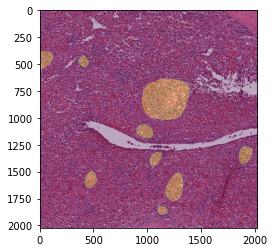

In [13]:
image = tifffile.imread('../input/hubmap-organ-segmentation/test_images/10078.tiff')
rle = sub['rle'][0]
mask =  rle_decode(rle,2023,2023,1)
plt.imshow(image)
plt.imshow(mask, alpha=0.3)